## Statistical downscaling in cross-validation mode

This notebook provides an illustrative example of how to perform statistical downscaling in cross-validation mode making use of [climate4R](https://github.com/SantanderMetGroup/climate4R) (C4R), an R framework developed by the [Santander Meteorology Group](https://github.com/SantanderMetGroup). In particular, we focus on the ARPAV vand ConfidesaTBV stations considered during the project and downscale precipitation and maximum temperature for the period 1991-2020.

In [1]:
rm(list = ls())  # removing all objects from the current R session

## loading C4R libraries
library(loadeR) 
library(transformeR)
library(downscaleR)
library(visualizeR)

## loading other libraries which will be used for plotting purposes
library(lattice)  
library(sp)  
library(RColorBrewer)  

Loading required package: rJava

Loading required package: loadeR.java

Java version 25x amd64 by N/A detected

The maximum JVM heap space available is: 1.93 GB

NetCDF Java Library Version: 5.9.1.1 (Built-On: 2025-09-16T11:37:12-0600) loaded and ready

You can manually set the NetCDF Java Library version before loading the package:
options(loadeR.java_forced_version = "X.Y.Z")
library(loadeR.java)

netCDF-Java CLASSPATH from env LOADER_JAVA_CLASSPATH + bundled java package directory: /srv/conda/envs/notebook/lib/java/toolsUI.jar:/srv/conda/envs/notebook/lib/R/library/loadeR.java/java:/srv/conda/envs/notebook/lib/R/library/loadeR.java/java/netcdfAll-4.6.0-SNAPSHOT.jar

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.4 (2025-08-07) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.5 (2026-01-21) is loaded

Please see 'citation("transformeR")' to cite this package.



ERROR: Error in library(downscaleR): there is no package called ‘downscaleR’


In [3]:
## setting working directory
work.dir <- "/home/ana/WORK_local/DATA/Prosecco/data4notebooks/"

Before diving into the data, let's define some variables we will later use for plotting purposes:

In [ ]:
## preparing polygons for provinces
sh <- readRDS(paste0(work.dir,"italy_admin.rds")) # reading shape file
proj4string(sh) = CRS("+init=epsg:4326")
sh = as(sh, "SpatialPolygons")

## geographical domain limits 
lats <- c(45.45,46.15)
lons <- c(11.7,12.8)

Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+init=epsg:4326")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +datum=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”


## Predictands
We start by loading our predictands variables, which are already prepared in an *Rdata* object.

In [5]:
## loading observations 
load(paste0(work.dir, "/observations_subset_1991-2020.Rdata"))

To plot their climatologies, we can use the *spatialPlot* function. Let's start with maximum temperature.

[2026-02-15 21:23:27.926077] - Computing climatology...

[2026-02-15 21:23:27.934083] - Done.



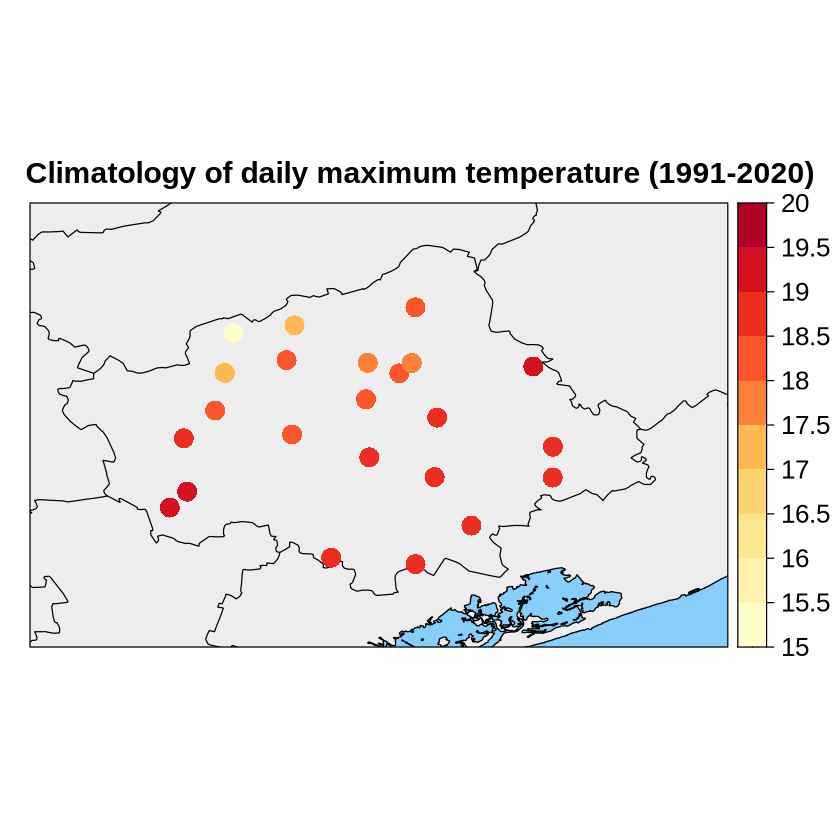

In [ ]:
## preparing colorbar
bk <-  seq(15,20,0.5)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)

## plotting map
spatialPlot(climatology(tasmax_obs), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of daily maximum temperature (1991-2020)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, 
                                 args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Now let's plot the climatology for relative humidity.
**¿Por qué no pintamos precipitación? Que es de la que se hace downscaling luego**

[2026-02-15 21:23:28.74599] - Computing climatology...

[2026-02-15 21:23:28.74888] - Done.



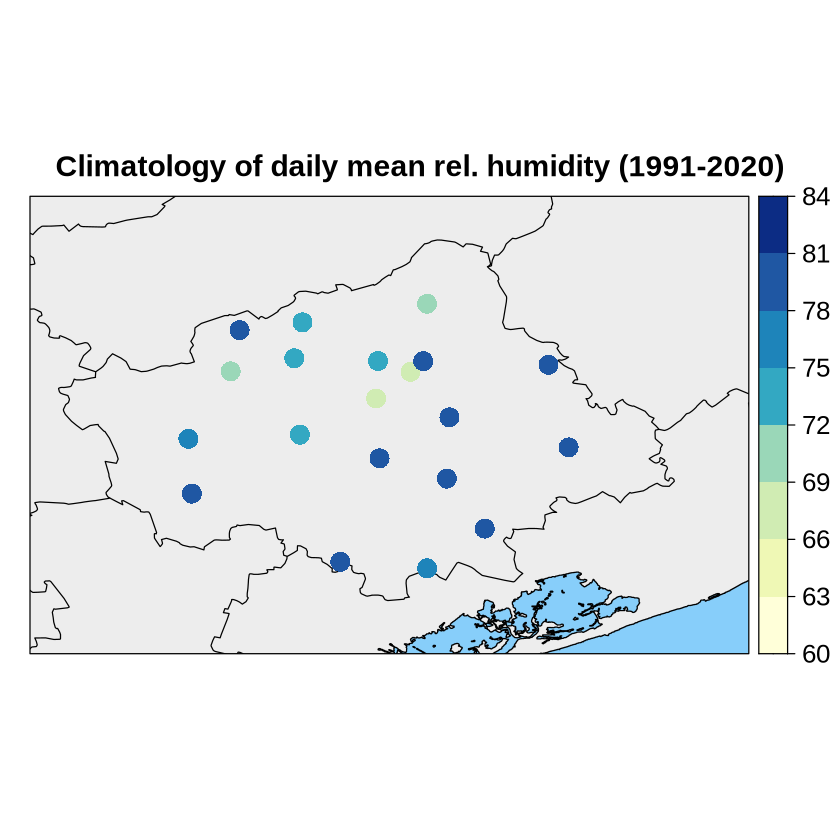

In [ ]:
## preparing colorbar
bk <-  seq(60,84,3)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap <- cols(cmap.nbins)

## plotting map
spatialPlot(climatology(hurs_obs), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Climatology of daily mean rel. humidity (1991-2020)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

## Predictors
Now, we need to load the predictor variables that will be used for downscaling. These variables, which come from the ERA5 reanalysis, have been already upscaled from their native resolution (0.25º) to a regular 2º grid which will be also used for the Global Climate Models (GCMs) in a following notebook.

In [8]:
## loading ERA5 predictors
load(paste0(work.dir,"/ERA5_P8predictors_2deg_1991-2020.Rdata"))

In [9]:
## predictor variables
cbind(getVarNames(x), attr(x$Variable, "units"))

[1] "u@500" "u@700" "u@850" "v@500" "v@700" "v@850" "z@500" "z@850" "t@500"
[10] "t@700" "t@850" "q@500" "q@850" "t2m"

[1] "m s**-1"    "m s**-1"    "m s**-1"    "m s**-1"    "m s**-1"   
 [6] "m s**-1"    "m**2 s**-2" "m**2 s**-2" "K"          "K"         
[11] "K"          "kg kg**-1"  "kg kg**-1"  "K"

As we did for the predictands, we will also plot the climatology of all the predictors considered. 

In [ ]:
## computing the climatology of all predictor variables at once
x_clim <- climatology(x)

Let's start with the climatology *u* (eastward wind) and *v* (northward wind), which are provided in three different vertical levels: 500, 700 and 850 hPa.

[2026-02-15 21:23:29.5146] - Computing climatology...

[2026-02-15 21:23:29.655268] - Done.



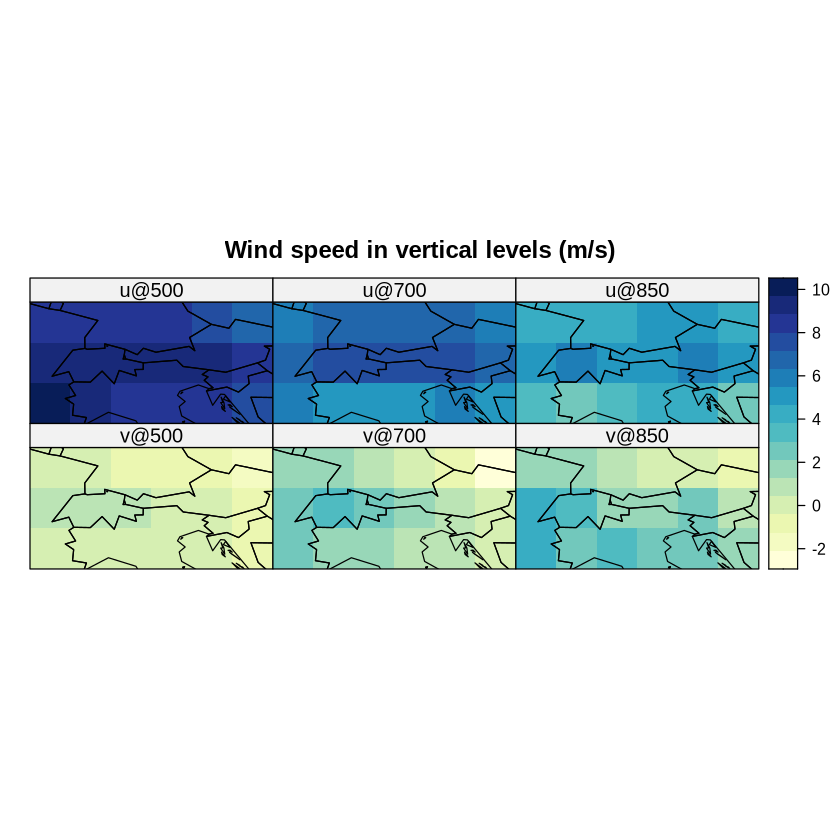

In [10]:
## plotting maps
spatialPlot(bindGrid(subsetGrid(x_clim, var= "u@500"), subsetGrid(x_clim, var= "u@700"), subsetGrid(x_clim, var= "u@850"), 
    subsetGrid(x_clim, var= "v@500"), subsetGrid(x_clim, var= "v@700"), subsetGrid(x_clim, var= "v@850")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=getVarNames(x)[1:6], layout= c(3,2), color.theme = "YlGnBu",
    main= "Wind speed in vertical levels (m/s)")

Now, let's plot the climatology for *z* (geopotential height) at the two vertical leves considered (500 and 850 hPa). Together, these two variables give an idea of the troposhere's stability. 

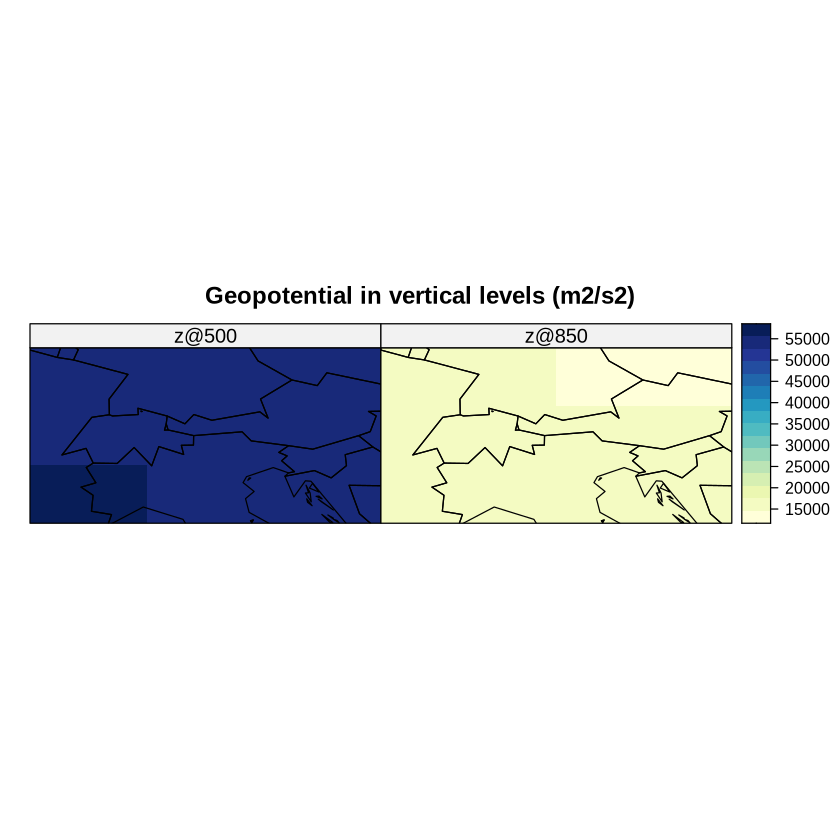

In [11]:
## plotting maps
spatialPlot(bindGrid(subsetGrid(x_clim, var= "z@500"), subsetGrid(x_clim, var= "z@850")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=getVarNames(x)[7:8], layout= c(2,1), color.theme = "YlGnBu",
    main= "Geopotential in vertical levels (m2/s2)")

Now, let's plot the climatology of *t* (air temperature) at the three vertical levels considered (500 hPa, 700 hPa, 850 hPa) plus at surface (*t2m*).

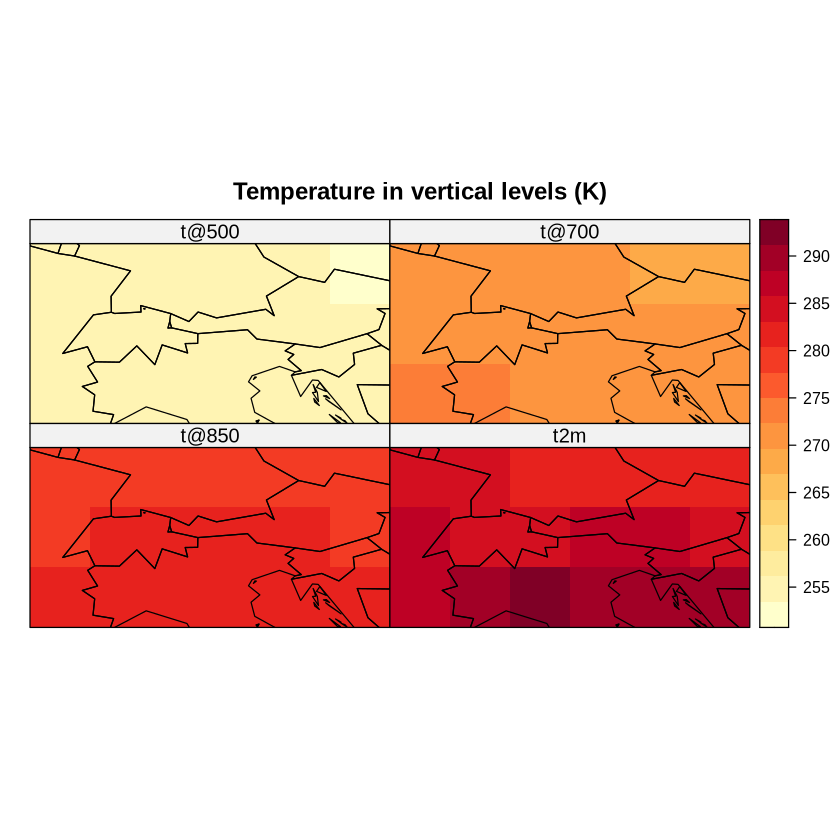

In [12]:
## plotting maps
spatialPlot(bindGrid(subsetGrid(x_clim, var= "t@500"), subsetGrid(x_clim, var= "t@700"), subsetGrid(x_clim, var= "t@850"), subsetGrid(x_clim, var= "t2m")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=c(getVarNames(x)[9:11],"t2m"), layout= c(2,2), color.theme = "YlOrRd",
    main= "Temperature in vertical levels (K)")

Last, we will plot the climatology for *q* (specific humidity) at 500 hPa and 850 hPa.

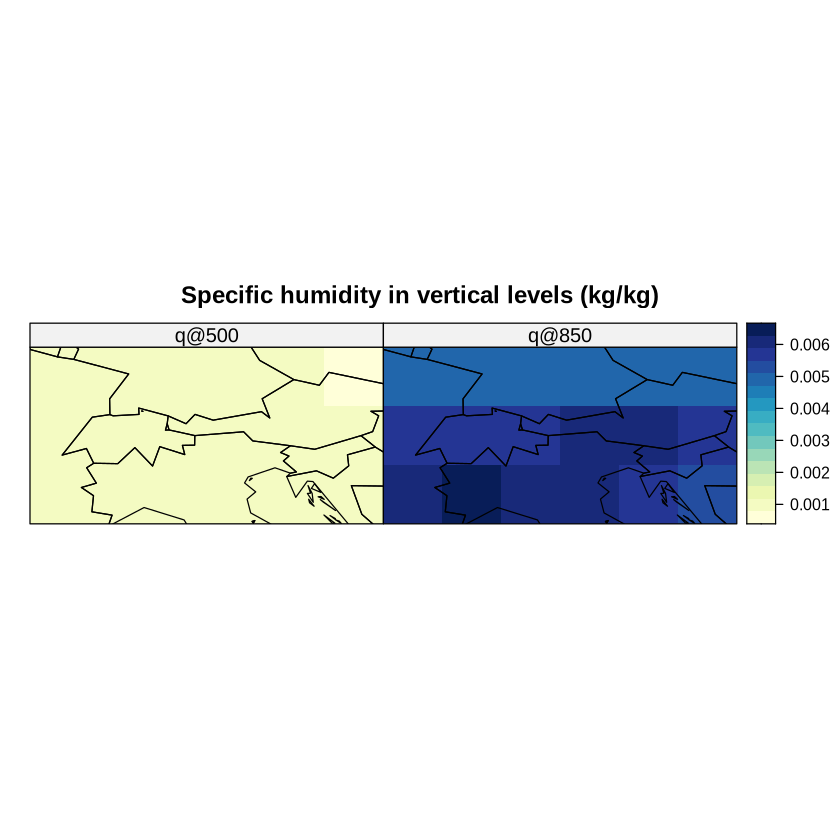

In [13]:
## plotting maps
spatialPlot(bindGrid(subsetGrid(x_clim, var= "q@500"), subsetGrid(x_clim, var= "q@850")), 
    backdrop.theme = "countries", as.table=TRUE, names.attr=getVarNames(x)[12:13], layout= c(2,1), color.theme = "YlGnBu",
    main= "Specific humidity in vertical levels (kg/kg)")

## Downscaling in cross-validation mode
Now that we are familiarized with the predictands and the predictors we will work with, we can start the downscaling process. We will follow here the *Perfect Prognosis* approach, in which the statistical/empirical models are fitted based on observed data, both for the predictors (ERA5) and predictands (ARPAV and ConfidesaTBV stations).

For precipitation and humidity, we will used the analog technique, which is based on the k-NN algorithm. Its basic principle is to look for similar atmospheric situations (i.e. analogs) within the historical database. Subsequently, a prediction is inferred from these analogs. This technique has been shown to perform very well for precipitation downscaling in many previous studies. However, its main limitation is that it cannot generate values outside the historical observed range, which constitutes a serious problem for variables such as temperature, which is known to increase substantially in future decades under global warming. Therefore, we will use multilinear regression (which is simple, interpretable and has the ability to extrapolate) to downscale temperatures.

In all cases, it is important to apply an appropiate cross-validation framework to avoid model overfitting. Here, we will consider a 5-fold cross-validation. This means the 30 years available for calibration (1991-2020) are divided into 5 different sets of 6 years each. To give a prediction for each of these sets, the model is trained with the remaining 24 years. The process is repeated 5 times to obtain a continous prediction for the 30 years. 

In [14]:
nfold <- 5  # number of folds

### Precipitation
Let's start by downscaling precipitation. In this case, we use as predictors the principal components explaining the 95% of the variance. Principal components allow for reducing the dimensionality of the data without an important loss of information. 

The C4R function that allows for downscaling in cross-validation mode is *downscaleCV*.

**Si se hacen PCs, no haría falta estandarizar los datos, no? Se supone que la función lo hace ya internamente para el propio cálculo de las PCs**

In [15]:
## downscaling precipitation (in cross-validation mode)
pr_pred <- downscaleCV(x, pr_obs, folds = nfold, sampling.strategy = "kfold.random",
                        scaleGrid.args = list(type = "standardize"),
                        method = "analogs", 
                        prepareData.args = list("spatial.predictors" = list(which.combine = getVarNames(x), v.exp = 0.95)))

fold: 1 --> calculating...

[2026-02-15 21:23:51.986887] - Scaling ...

[2026-02-15 21:23:52.247668] - Done

[2026-02-15 21:23:52.249111] - Scaling ...

[2026-02-15 21:23:52.926832] - Done

[2026-02-15 21:23:53.323987] Performing PC analysis on 14 variables plus a combination ...

[2026-02-15 21:23:53.61207] Done.

fold: 2 --> calculating...

[2026-02-15 21:24:05.981606] - Scaling ...

[2026-02-15 21:24:06.107102] - Done

[2026-02-15 21:24:06.108338] - Scaling ...

[2026-02-15 21:24:06.514991] - Done

[2026-02-15 21:24:06.773478] Performing PC analysis on 14 variables plus a combination ...

[2026-02-15 21:24:07.042128] Done.

fold: 3 --> calculating...

[2026-02-15 21:24:18.917509] - Scaling ...

[2026-02-15 21:24:19.059838] - Done

[2026-02-15 21:24:19.061048] - Scaling ...

[2026-02-15 21:24:19.463832] - Done

[2026-02-15 21:24:19.73259] Performing PC analysis on 14 variables plus a combination ...

[2026-02-15 21:24:20.535017] Done.

fold: 4 --> calculating...

[2026-02-15 21:24:32

Once the downscaled precipitation is obtained, we need to validate our results. To do this, we calculate first the bias (mean error) of the predictions and plot this metric in a map:

[2026-02-15 21:24:58.436431] - Computing climatology...



[2026-02-15 21:24:58.439418] - Done.

[2026-02-15 21:24:58.447239] - Computing climatology...

[2026-02-15 21:24:58.451112] - Done.



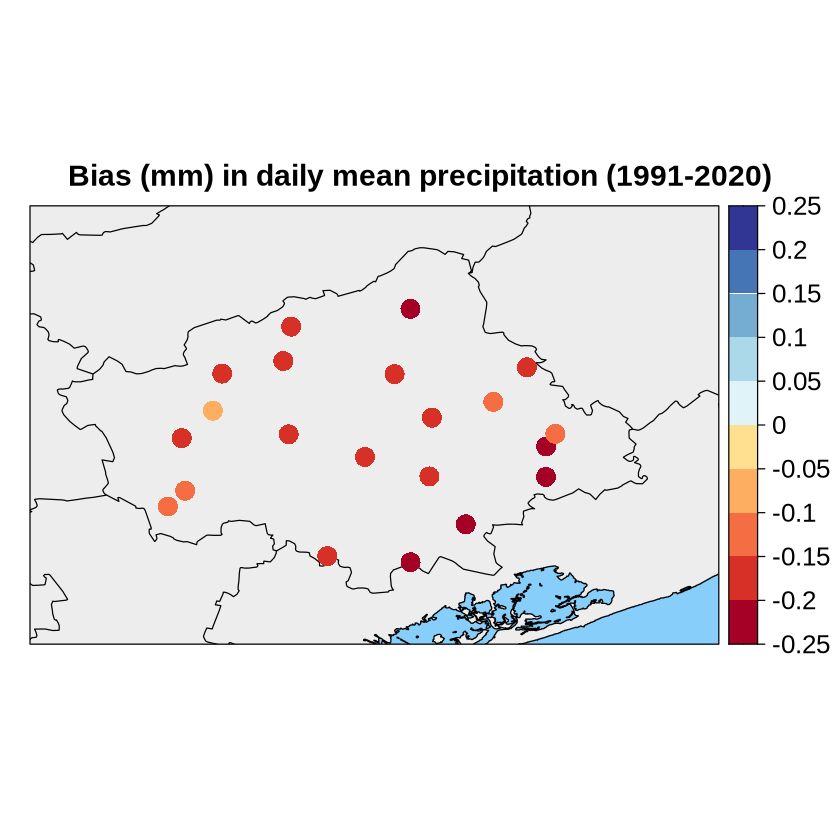

In [ ]:
## computing bias
bias <- gridArithmetics(climatology(pr_pred), climatology(pr_obs), operator = "-")

## preparing colorbar
bk <- seq(-0.25, 0.25, 0.05)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(11,"RdYlBu"))
cmap <- cols(cmap.nbins)

## plotting map
spatialPlot(bias, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Bias (mm) in daily mean precipitation (1991-2020)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

We could focus on accumulated precipitation for July and calculate the corresponding relative bias (in % with respect to the observed value):

In [17]:
## extracting observations and predictions for July
pr_obs_jul <- subsetGrid(pr_obs, season=7)
pr_pred_jul <- subsetGrid(pr_pred, season=7)

In [18]:
## aggregating the daily values to a monthly sum
pr_obs_jul_agg <- aggregateGrid(pr_obs_jul, aggr.m = list(FUN = sum, na.rm = TRUE))
pr_pred_jul_agg <- aggregateGrid(pr_pred_jul, aggr.m = list(FUN = sum, na.rm = TRUE))

[2026-02-15 21:24:58.898978] Performing monthly aggregation...

[2026-02-15 21:24:58.911739] Done.

[2026-02-15 21:24:58.927561] Performing monthly aggregation...

[2026-02-15 21:24:58.939257] Done.



[2026-02-15 21:24:58.983907] - Computing climatology...

[2026-02-15 21:24:58.986972] - Done.

[2026-02-15 21:24:58.991125] - Computing climatology...

[2026-02-15 21:24:58.992506] - Done.

[2026-02-15 21:24:58.994608] - Computing climatology...

[2026-02-15 21:24:58.995629] - Done.



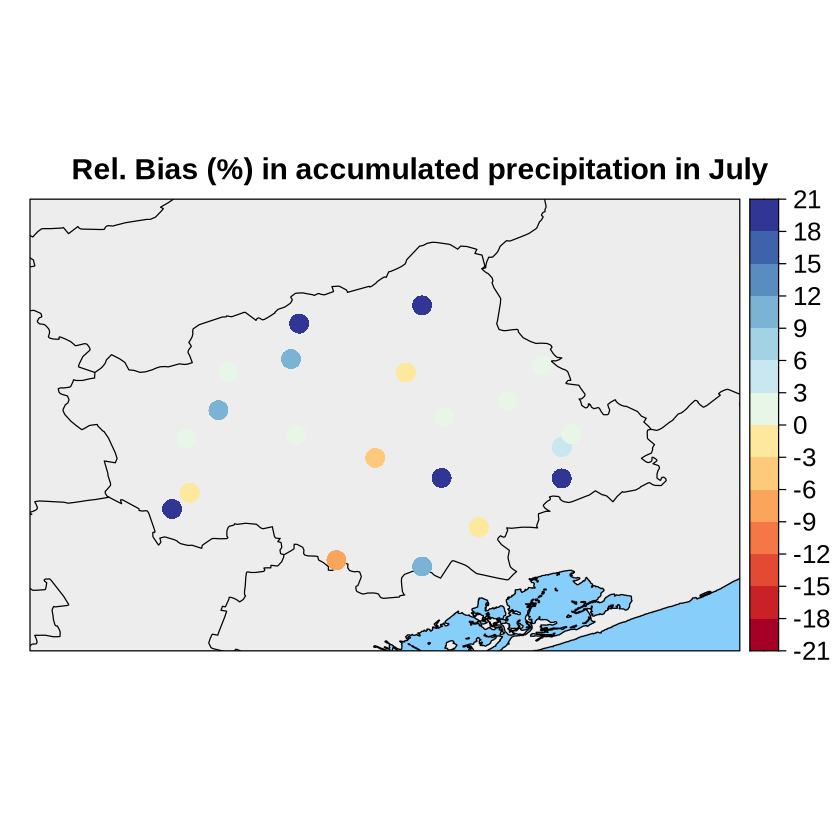

In [ ]:
## computing relative bias for accumulated precipitation in July
bias_rel <- gridArithmetics(climatology(pr_pred_jul_agg), climatology(pr_obs_jul_agg), 
                            climatology(pr_obs_jul_agg), 100, operator=c("-", "/", "*"))
## preparing colorbar
bk <- seq(-21, 21, 3)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(11,"RdYlBu"))
cmap <- cols(cmap.nbins)

## plotting map
spatialPlot(bias_rel, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk,  main = list(label="Rel. Bias (%) in accumulated precipitation in July", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, 
                                 args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

The next validation metric we are going to use is correlation. It gives an idea of how well/bad the predicted time-series follow the observed fluctuations. Correlation is constrained to the interval [-1,1]. A value equal to 1 (-1) would mean there is a perfectly direct (inverse) relationship between observations and predictions. A value equal to 0 would indicate there is no relationship at all.  

Typically, the *Spearman* (*Pearson*) correlation is used for precipitation (temperatures). 

In [20]:
## calculating Spearman correlation, for the entire year
correlation <- bias  # only to create a C4R object to fill with correlation values
for(i in 1:dim(pr_pred$Data)[2]) {  # loop that covers all the stations
    corr.aux <- cor(pr_pred$Data[,i], pr_obs$Data[,i], use = "complete.obs", method = "spearman")
    correlation$Data[,i] <- corr.aux
    rm(corr.aux)
}

In [1]:
## preparing colorbar
bk <- seq(0.1,1, 0.1)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(9,"OrRd"))
cmap <- cols(cmap.nbins)

## plotting map
spatialPlot(correlation, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")),
                        col.regions = cmap, set.min = min(bk), set.max = max(bk),
                        cuts = bk, main = list(label="Day to day correlation in precipitation (1991-2020)", cex=1.5),
                        par.strip.text = list(cex = 1),
                        colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

ERROR: Error in brewer.pal(9, "OrRd"): could not find function "brewer.pal"


### Maximum temperature
Now let's downscale maximum temperature. In this case, the method we will use is multilinear regression. As for precipitation, we will consider the principal components explaining the 95% of the variance under a 5-fold cross-validation scheme.

In [22]:
## downscaling maximum temperature (in cross-validation mode)
tasmax_pred <- downscaleCV(x, tasmax_obs, folds = nfold, sampling.strategy = "kfold.random",
                        scaleGrid.args = list(type = "standardize"),
                        method = "GLM", family = gaussian(link = "identity"),
                        prepareData.args = list("spatial.predictors" = list(which.combine = 
                        getVarNames(x), v.exp = 0.95)))

fold: 1 --> calculating...

[2026-02-15 21:25:00.160456] - Scaling ...

[2026-02-15 21:25:00.301798] - Done

[2026-02-15 21:25:00.302875] - Scaling ...

[2026-02-15 21:25:00.709685] - Done

[2026-02-15 21:25:00.962582] Performing PC analysis on 14 variables plus a combination ...

[2026-02-15 21:25:01.557251] Done.

fold: 2 --> calculating...

[2026-02-15 21:25:01.882788] - Scaling ...

[2026-02-15 21:25:02.008521] - Done

[2026-02-15 21:25:02.00984] - Scaling ...

[2026-02-15 21:25:02.405425] - Done

[2026-02-15 21:25:02.670478] Performing PC analysis on 14 variables plus a combination ...

[2026-02-15 21:25:03.422607] Done.

fold: 3 --> calculating...

[2026-02-15 21:25:03.792054] - Scaling ...

[2026-02-15 21:25:03.929759] - Done

[2026-02-15 21:25:03.93093] - Scaling ...

[2026-02-15 21:25:04.309607] - Done

[2026-02-15 21:25:04.588055] Performing PC analysis on 14 variables plus a combination ...

[2026-02-15 21:25:04.857726] Done.

fold: 4 --> calculating...

[2026-02-15 21:25:05

Once the predictions are obtained, we need to validate them. We could start by computing the bias (mean error) for July.

**¿Por qué no hacemos como con la precipitación: bias para todo el año, bias para Julio y correlación para todo el año?**

In [ ]:
## extracting daily observations and daily predictions for July
tasmax_obs_jul <- subsetGrid(tasmax_obs, season=7)
tasmax_pred_jul <- subsetGrid(tasmax_pred, season=7)

[2026-02-15 21:25:08.525796] - Computing climatology...

[2026-02-15 21:25:08.528159] - Done.

[2026-02-15 21:25:08.531154] - Computing climatology...

[2026-02-15 21:25:08.532559] - Done.



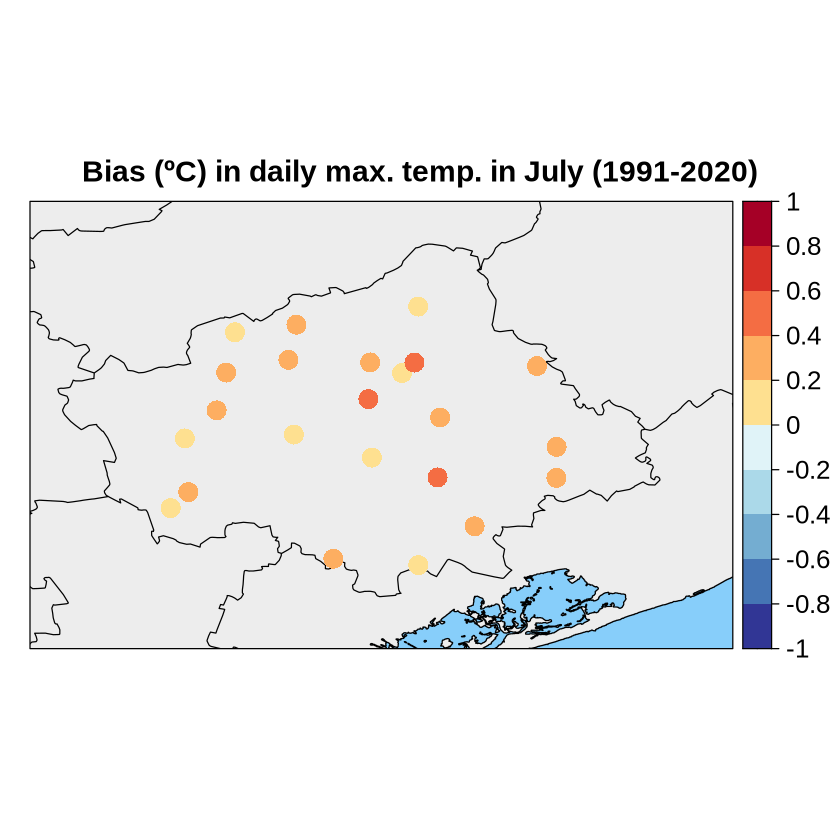

In [ ]:
## computing the bias (mean error) for July
bias <- gridArithmetics(climatology(tasmax_pred_jul), climatology(tasmax_obs_jul), operator = "-")

## preparing colorbar
bk <- seq(-1, 1, 0.2) 
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(11,"RdYlBu"))
cmap <- rev(cols(cmap.nbins))

## plotting map
spatialPlot(bias, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk), 
    cuts = bk,  main = list(label="Bias (ºC) in daily max. temp. in July (1991-2020)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list( fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Now, we could compute the *Pearson* correlation, for the entire year:

In [25]:
## computing Pearson correlation, for the entire year
correlation <- bias  # only to create a C4R object to fill with correlation values
for(i in 1:dim(tasmax_pred$Data)[2]){
    corr.aux <- cor(tasmax_pred$Data[,i], tasmax_obs$Data[,i], use="complete.obs", method = "pearson")
    correlation$Data[,i] <- corr.aux
    rm(corr.aux)
}

In [ ]:
## preparing colorbar
bk <- seq(0.1,1, 0.1)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(9,"OrRd"))
cmap <- cols(cmap.nbins)

## plotting map
spatialPlot(correlation, cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")),
                        col.regions = cmap, set.min = min(bk), set.max = max(bk),
                        cuts = bk, main = list(label="Day to day correlation in max. temperature (1991-2020)", cex=1.5),
                        par.strip.text = list(cex = 1),
                        colorkey = list(right = list( fun = draw.colorkey, 
                                                     args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

**Pregunta**: ¿Por qué crees que los valores obtenidos son tan altos?